In [1]:
import os
path = os.path.join('/home/santiago/Documents/dev/reservoirpy')
import sys
sys.path.insert(0,path)
import pandas as pd
import numpy as np
from reservoirpy.materialbalancepy import mbe as mb
from reservoirpy.pvtpy import black_oil as bl
import matplotlib.pyplot as plt

In [2]:
data = np.array([
    [0.1000000, 0.0000000, 1.0000000, 0],
    [0.2000000, 0.0138408, 0.6869530, 0],
    [0.3000000, 0.0553633, 0.4471809, 0],
    [0.4000000, 0.1245675, 0.2709139, 0],
    [0.5000000, 0.2214533, 0.1483818, 0],
    [0.6000000, 0.3460208, 0.0698148, 0],
    [0.7000000, 0.4982699, 0.0254427, 0],
    [0.8000000, 0.6782007, 0.0054956, 0],
    [0.9000000, 0.8858131, 0.0002035, 0],
    [0.9500000, 1.0000000, 0.0000000, 0],
    [1.0000000, 1.0000000, 0.0000000, 0],
])
krwo = mb.kr(data,columns=['sw','krw','kro','pc'])
krwo

,krw,kro,pc
sw,,,
0.10,0.000000,1.000000,0.0
0.20,0.013841,0.686953,0.0
0.30,0.055363,0.447181,0.0
0.40,0.124567,0.270914,0.0
0.50,0.221453,0.148382,0.0
0.60,0.346021,0.069815,0.0
0.70,0.498270,0.025443,0.0
0.80,0.678201,0.005496,0.0
0.90,0.885813,0.000204,0.0


In [3]:
data = np.array([
    [0.81, 0.018],
    [0.76, 0.063],
    [0.60, 0.850],
    [0.50, 3.350],
    [0.40, 10.2]

])
krgo_ratio = mb.kr(data,columns=['so','krg_kro'],index='so')
krgo_ratio

,krg_kro
so,
0.81,0.018
0.76,0.063
0.60,0.850
0.50,3.350
0.40,10.200


In [4]:
krgo_ratio.interpolate(0.50001)

,krg_kro
saturation,
0.50001,3.34975


In [5]:
# Oil PVT
oil_pvt = bl.pvt({
    'pressure': [2925,2100,1800,1500],
    'bo':[1.429,1.480,1.468,1.440],
    'bt':[1.429,1.480,1.559,1.792],
    'rs':[1340,1340,1280,1150],
    'bg':[0.001,0.001283,0.001518,0.00183],
    'muo':[10,7,7.5,8],
    'mur':[0,34.1,38.3,42.4]
})

formation = 'fm1'
api = 25
pb = 2100
rsi = 1340
temp = 175

o = bl.oil(
    formation=formation,
    api=api,
    pb=pb,
    rsb=rsi,
    temp=temp,
    pvt=oil_pvt
)
o.pvt

,bo,bt,rs,bg,muo,mur
pressure,,,,,,
2925,1.429,1.429,1340,0.001000,10.0,0.0
2100,1.480,1.480,1340,0.001283,7.0,34.1
1800,1.468,1.559,1280,0.001518,7.5,38.3
1500,1.440,1.792,1150,0.001830,8.0,42.4


In [6]:
# GasPVT
gas_pvt = bl.pvt({
    'pressure': [2925,2100,1800,1500],
    'bg':[0.001,0.001283,0.001518,0.00183],
    'mug':[0,0.205,0.1958,0.1886]
})

formation = 'fm1'

temp = 175
g = bl.gas(
    formation=formation,
    pvt = gas_pvt,
    temp=temp
)
g.pvt

,bg,mug
pressure,,
2925,0.001000,0.0000
2100,0.001283,0.2050
1800,0.001518,0.1958
1500,0.001830,0.1886


In [7]:
# Water

w = bl.water(
    formation=formation,
    pb = pb,
    temp = temp)

w.pvt_from_correlations(start_pressure=1000,end_pressure=3000,n=5)
w.pvt['cw']=3.6e-6
w.pvt

,rsw,cw,bw,muw,rhow
pressure,,,,,
1000.0,6.803417,0.000004,1.029221,0.375964,60.628376
1500.0,8.975257,0.000004,1.028531,0.375964,60.669053
2000.0,11.044822,0.000004,1.027709,0.375964,60.717562
2500.0,13.012112,0.000004,1.026144,0.375964,60.810184
3000.0,14.877126,0.000004,1.024409,0.375964,60.913157


In [8]:
swi=0.15
cf=4.9e-6
ooip=10e6

In [9]:
res1 = mb.oil_reservoir(
    n=ooip,
    swi=swi,
    cf = cf,
    oil = o,
    water = w,
    gas = g,
    pi=2925,    
    kr_wo = krwo,
    kr_go = krgo_ratio
)


In [10]:
r = np.linspace(2100,2900,10)[::-1]

r

array([2900.        , 2811.11111111, 2722.22222222, 2633.33333333,
       2544.44444444, 2455.55555556, 2366.66666667, 2277.77777778,
       2188.88888889, 2100.        ])

In [11]:
res1.oil.pvt.interpolate([2925,2900])

,bo,bt,rs,bg,muo,mur
pressure,,,,,,
2925,1.429000,1.429000,1340.0,0.001000,10.000000,0.000000
2900,1.430545,1.430545,1340.0,0.001009,9.909091,1.033333


In [12]:
f = res1.forecast_np(r,wp=False)
print(f.tail())

                        np            gp   wp  wor     gor  bsw        sw  \
2455.555556  177759.860063  2.381982e+08  0.0  0.0  1340.0  0.0  0.148155   
2366.666667  210966.900597  2.826956e+08  0.0  0.0  1340.0  0.0  0.147835   
2277.777778  244033.435243  3.270048e+08  0.0  0.0  1340.0  0.0  0.147525   
2188.888889  276960.511231  3.711271e+08  0.0  0.0  1340.0  0.0  0.147224   
2100.000000  309749.164127  4.150639e+08  0.0  0.0  1340.0  0.0  0.146932   

                   so   sg  
2455.555556  0.851845  0.0  
2366.666667  0.852165  0.0  
2277.777778  0.852475  0.0  
2188.888889  0.852776  0.0  
2100.000000  0.853068  0.0  


                np            gp   wp  wor          gor  bsw        sw  \
2925  0.000000e+00  0.000000e+00  0.0  0.0     0.000000  0.0  0.150000   
2100  3.055626e+05  4.094539e+08  0.0  0.0  1340.000000  0.0  0.146564   
1800  4.160490e+05  6.368142e+08  0.0  0.0  1051.007315  0.0  0.146564   
1500  1.225669e+06  1.878761e+09  0.0  0.0  4638.604191  0.0  0.146564   

            so        sg  
2925  0.850000  0.000000  
2100  0.853436  0.000000  
1800  0.836869  0.016567  
1500  0.751559  0.101877  


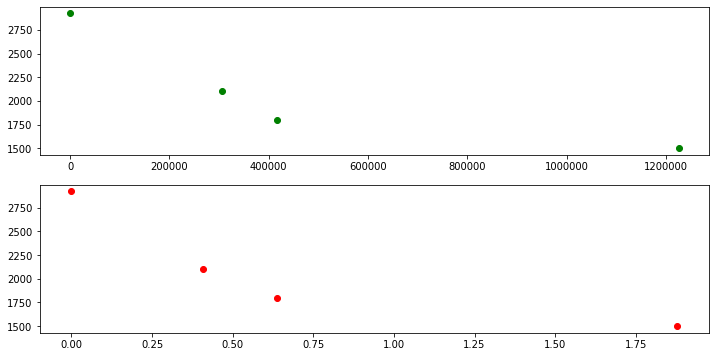

In [20]:
new_r = np.linspace(1500,2800,5)[::-1]
new_r = [2100,1800,1500]
f_new = res1.forecast_np(new_r,wp=False)
print(f_new)

fig, ax = plt.subplots(2,1, figsize=(12,6))
ax[0].scatter(f_new['np'],f_new.index, color='green')
ax[1].scatter(f_new['gp']/1e9,f_new.index, color='red')

In [15]:
2.16e9/1e6

2160.0

In [13]:
f=res1.forecast_np(r,wp=True, er_np=0.01)
f

2
3
3
3
3
3
3
3
3
2


,np,gp,wp,wor,bsw,sw,so,sg
2925.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.150000,0.850000,0.0
2900.000000,8895.082484,1.191941e+07,955.545013,0.216245,0.177797,0.149838,0.850162,0.0
2811.111111,38340.346371,5.137606e+07,7232.306909,0.208386,0.172450,0.149087,0.850913,0.0
2722.222222,67843.577737,9.091039e+07,13244.548811,0.197777,0.165120,0.148361,0.851639,0.0
2633.333333,97426.870148,1.305520e+08,18960.639093,0.187548,0.157929,0.147661,0.852339,0.0
2544.444444,127083.362049,1.702917e+08,24389.612328,0.177691,0.150881,0.146987,0.853013,0.0
2455.555556,156806.457319,2.101207e+08,29540.303611,0.168188,0.143973,0.146337,0.853663,0.0
2366.666667,186589.869071,2.500304e+08,34421.193285,0.159020,0.137202,0.145713,0.854287,0.0
2277.777778,216427.563280,2.900129e+08,39040.414395,0.150171,0.130564,0.145113,0.854887,0.0
2188.888889,246313.796748,3.300605e+08,43405.772718,0.141623,0.124054,0.144536,0.855464,0.0


In [14]:
f_wp = res1.forecast_np(r,wp=True)
print(f_wp.tail())

2
2
2
2
2
2
2
2
2
2
                        np            gp            wp       wor       bsw  \
2455.555556  157238.516607  2.106996e+08  28931.502778  0.168323  0.144073   
2366.666667  187069.546317  2.506732e+08  33744.506003  0.159170  0.137314   
2277.777778  216946.154205  2.907078e+08  38308.056699  0.150331  0.130685   
2188.888889  246863.974622  3.307977e+08  42628.069579  0.141789  0.124182   
2100.000000  276818.722229  3.709371e+08  46710.408909  0.133530  0.117800   

                   sw        so   sg  
2455.555556  0.146375  0.853625  0.0  
2366.666667  0.145755  0.854245  0.0  
2277.777778  0.145158  0.854842  0.0  
2188.888889  0.144584  0.855416  0.0  
2100.000000  0.144033  0.855967  0.0  


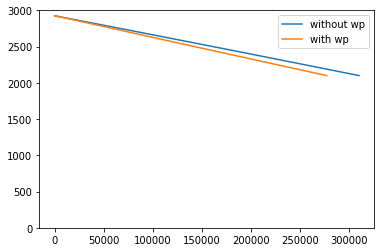

In [15]:
fig, ax = plt.subplots()
ax.plot(f['np'], f.index, label='without wp')
ax.plot(f_wp['np'], f_wp.index, label='with wp')
ax.set_ylim(0,3000)
ax.legend()

In [10]:
aq = mb.pot_aquifer(k=9987)

In [11]:
res1_aq = mb.oil_reservoir(
    n=ooip,
    swi=swi,
    cf = cf,
    oil = o,
    water = w,
    pi=2925,    
    kr_wo = kr,
    aquifer = aq
)

In [12]:
f_aq= res1_aq.forecast_np(r,wp=True)
f_aq

sw  0.15
fw  0.17779722110885893
sw  [0.16285298]
fw  0.21638579968329358
sw  [0.20634045]
fw  0.3766286235104727
sw  [0.23277747]
fw  0.5175819408040474
sw  [0.24468122]
fw  0.5614734714325276
sw  [0.26314438]
fw  0.6226349229902481
sw  [0.27092386]
fw  0.6396833379862117
sw  [0.2876792]
fw  0.6819026699751368
sw  [0.29101517]
fw  0.6821029356410945
sw  [0.31066752]
fw  0.7316985072160734


,np,gp,wp,wor,bsw,sw
2900.000000,1.618515e+05,2.168810e+08,3.499957e+04,0.216245,0.177797,0.150000
2811.111111,7.086057e+05,9.495317e+08,1.956731e+05,0.276138,0.216386,0.162853
2722.222222,1.052342e+06,1.410139e+09,6.358044e+05,0.604180,0.376629,0.206340
2633.333333,1.224619e+06,1.640990e+09,1.313883e+06,1.072891,0.517582,0.232777
2544.444444,1.471513e+06,1.971827e+09,1.884071e+06,1.280364,0.561473,0.244681
2455.555556,1.593356e+06,2.135097e+09,2.628964e+06,1.649954,0.622635,0.263144
2366.666667,1.817393e+06,2.435306e+09,3.226484e+06,1.775337,0.639683,0.270924
2277.777778,1.886178e+06,2.527479e+09,4.043385e+06,2.143692,0.681903,0.287679
2188.888889,2.140484e+06,2.868249e+09,4.592778e+06,2.145672,0.682103,0.291015
2100.000000,2.060840e+06,2.761525e+09,5.620220e+06,2.727150,0.731699,0.310668


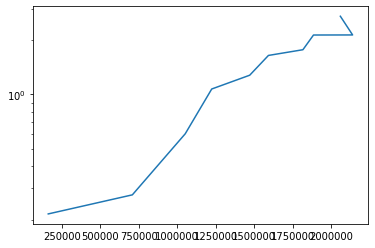

In [13]:
plt.plot(f_aq['np'],f_aq['wor'])
plt.yscale('log')

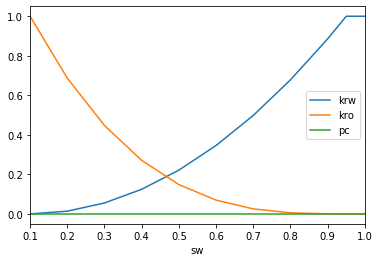

In [14]:
kr.plot()

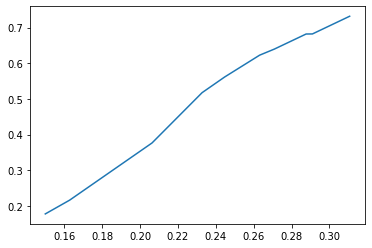

In [19]:
plt.plot(f_aq['sw'],f_aq['bsw'])